# Trabalho Infraestrutura Cassandra - Instituto Infnet

## Introdução

### Proposta do trabalho

Esse trabalho tem a proposta de preparar um ambiente Cassandra capaz de receber uma base de dados para consulta, sobre a qual depois será feita uma análise de dados utilizando o Apache Spark.

### Diferenças entre bases de dados SQL e NoSQL

As bases de dados SQL (Structured Query Language) e NoSQL (Not Only SQL) diferem em vários aspectos, incluindo o modelo de dados, o sistema de gerenciamento e outras características considerando principalmente o teorema CAP (Consistency, Availability, Partition Tolerance) e as propriedades ACID (Atomicity, Consistency, Isolation, and Durability) e BASE (Basically Available, Soft state, and Eventual consistency).

#### Bases de Dados SQL
- **Modelo de Dados**: SQL utiliza um modelo relacional, onde os dados são organizados em tabelas com esquemas predefinidos. ex: MySQL, PostgreSQL, Oracle.
- **Teorema CAP**: Tende a priorizar consistência sobre disponibilidade e tolerância a partições. Se um nó falha, o sistema pode tornar-se indisponível para manter a consistência.
- **Propriedades ACID**: Garante Atomicidade, Consistência, Isolamento e Durabilidade das transações.
- **Exemplo de uso**: Um sistema financeiro que precisa manter a consistência rigorosa para garantir a precisão das transações.

#### Bases de Dados NoSQL:
- **Modelo de Dados**: NoSQL pode ter diversos modelos de dados, como chave-valor, documento, coluna, e grafos ex: MongoDB (documento), Cassandra (coluna), Redis (chave-valor), Neo4j(grafo).
- **Teorema CAP**: Tende a priorizar disponibilidade e tolerância a partições sobre consistência. Em caso de falha de nó, o sistema ainda permanece disponível, mesmo que a consistência seja temporariamente comprometida.
- **Propriedades BASE**: O sistema sempre responde, mesmo que com falhas e apesar de inconsistentes eventuais.
- **Exemplo de uso**: Um sistema de análise de Big Data que lida com grandes volumes de dados e prioriza a escalabilidade e a disponibilidade sobre a consistência estrita.

### Sobre o dataset

O conjunto de dados analisado está disponível no [kaggle](https://www.kaggle.com/datasets/mcamera/brazil-highway-traffic-accidents) e contém dados de acidentes nas rodovias federais do Brasil entre 2007 e 2021 em vários níveis de granularidade.

O nível de granularidade escolhido foi ‘acidentes por pessoa’ e, como houve uma mudança no sistema de registro desses dados em 2017, esta análise ficou restrita ao período de 2017 a 2021. A base de dados tratada para análise, assim como os resultados da análise, se encontra no [google drive](https://drive.google.com/drive/folders/1Sk6OiW3U-MJZEdN9i5q8h3tQFSfsoo0b?usp=drive_link)

### Descrição das colunas

A tabela abaixo contém a descrição do conteúdo de cada coluna na base de dados original.

| Coluna                 | Descrição                                          | 
| :--------------------- | :--------------------------------------------------|
| id                     | ID do acidente                                     | 
| data_inversa           | Data quando ocorreu o acidente                     | 
| dia_semana             | Dia da semana quando ocorreu o acidente            | 
| horario                | Horário quando ocorreu o acidente                  | 
| uf                     | Unidade Federativa onde ocorreu o acidente         | 
| br                     | Rodovia onde ocorreu o acidente                    | 
| km                     | Quilômetro da rodovia onde ocorreu o acidente      |  
| municipio              | Cidade onde ocorreu o acidente                     | 
| causa_acidente         | Causa do acidente                                  | 
| tipo_acidente          | Tipo de acidente                                   | 
| classificacao_acidente | Classificação do acidente                          | 
| fase_dia               | Período do dia quando aconteceu o acidente         | 
| sentido_via            | Sentido da via onde aconteceu o acidente           | 
| condicao_metereologica | Condição metereológica quando aconteceu o acidente | 
| tipo_pista             | Tipo de pista onde aconteceu o acidente            | 
| tracado_via            | Traçado da via onde aconteceu o acidente           | 
| uso_solo               | Se o veículo saiu da pista no acidente             | 
| id_veiculo             | ID do veículo envolvido no acidente                | 
| tipo_veiculo           | Tipo de veículo envolvido no acidente              |
| marca                  | marca do veículo envolvido no acidnete             |
| ano_fabricacao_veiculo | Ano de fabricaçãp dp veículo envolvido no acidente | 
| pesid                  | ID da pessoa envolvida no acidente                 | 
| tipo_envolvido         | Tipo de pessoa envolvida no acidente               | 
| estado_fisico          | Estado físico da pessoa envolvida no acidente      |
| idade                  | Idade da pessoa envolvida no acidente              |
| sexo                   | Sexo da pessoa envolvida no                        |

### Hipóteses, pergunta de negócio e modelo de dados

Sobre a base de dados em questão, foram estabalecidas as seguintes hipóteses:

1. Acidentes cuja causa se deve ao condutor do veículo ter dormido são mais comuns quando se têm apenas uma pessoa no veículo.
2. Acidentes cuja causa se deve à ingestão de álcool ou outra substância, pelo pedestre ou condutor, são mais comuns durante a noite.

Para ambas as hipóteses se presumiu que a busca deveria ser orientada pelas possíveis causas de acidentes, dentro do total de acidentes disponível na amostra. Sendo assim, o modelo de dados para a tabela criada ficou definido conforme a figura abaixo, onde **Q1 - Busca de acidentes por causa**.

![](./data_model.png)


## Preparação do ambiente
O ambiente que recebeu a base de dados consiste em um cluster de nó único, criado com Docker, no qual foi criado um keyspace 'acidentes' e uma tabela 'acidentes_por_causa'.

### Criação de Docker Network
```
docker network create cassandra-network
```
![](./img/create_network.jpg)


### Criação de Cluster Cassandra com Docker
```
docker run --name cassandra-node --network cassandra-network -p 9042:9042 -d cassandra:4.0
```
![](./img/run_cassandra_container.jpg)

### Verificação de status do cluster
```
docker exec cassandra-node nodetool status
```
![](./img/cluster_status.jpg)

### Cópia do arquivo csv para container
```
docker cp ./acidentes_por_causa.csv cassandra-node:/opt/cassandra
```
![](./img/copy_file.jpg)

### Criação do keyspace
```
CREATE KEYSPACE IF NOT EXISTS acidentes WITH REPLICATION =
{ 'class' : 'SimpleStrategy',
'replication_factor' : '1'
};
```
![](./img/create_keyspace.jpg)

### Criação da tabela
```
CREATE TABLE IF NOT EXISTS acidentes.acidentes_por_causa (
    causa_acidente VARCHAR,
    pesid INT,
    id INT,
    id_veiculo INT,
    tipo_envolvido VARCHAR,
    fase_dia VARCHAR,
    PRIMARY KEY (causa_acidente, pesid)
);
```
![](./img/create_table.jpg)

### Carregamento de dados para a tabela
```
COPY acidentes_por_causa (causa_acidente, pesid, id, id_veiculo, tipo_envolvido, fase_dia)
FROM 'acidentes_por_causa.csv'
WITH HEADER = true;
```
![](./img/load_table.jpg)

## Análise de dados

### Considerações

Em um ambiente produtivo, o recomendável seria utilizar um conector que permitisse a comunicação direta do spark com o cluster cassandra. Contudo, por dificuldades de configuração do conector no ambiente local, foi utilizado a biblioteca cassandra-cluster para se comunicar com o cluster em execução e extrair os dados.

In [26]:
from cassandra.cluster import Cluster
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

### Estabelecimento de comunicação com cluster

A porta padrão de comunicação é a 9042 e a sessão foi diretamente estabelecida com o keyspace 'acidentes'

In [27]:
cluster = Cluster(["127.0.0.1"])
session = cluster.connect("acidentes")

### Carregamento do DataFrame

In [28]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

spark.sparkContext.setLogLevel("OFF")

In [29]:
data = session.execute(
    "SELECT causa_acidente, pesid, id, id_veiculo, fase_dia, tipo_envolvido FROM acidentes_por_causa"
)

In [30]:
schema = StructType(
    [
        StructField("causa_acidente", StringType(), True),
        StructField("pesid", IntegerType(), True),
        StructField("id", IntegerType(), True),
        StructField("id_veiculo", IntegerType(), True),
        StructField("fase_dia", StringType(), True),
        StructField("tipo_envolvido", StringType(), True),
    ]
)

In [31]:
df = spark.createDataFrame(data, schema)

### Análise

In [32]:
df.show(10, truncate=False)

+----------------------+------+------+----------+-----------+--------------+
|causa_acidente        |pesid |id    |id_veiculo|fase_dia   |tipo_envolvido|
+----------------------+------+------+----------+-----------+--------------+
|Mal súbito do condutor|738367|331811|595240    |Pleno dia  |Condutor      |
|Mal súbito do condutor|738694|331956|595464    |Plena Noite|Condutor      |
|Mal súbito do condutor|738924|332054|595607    |Pleno dia  |Condutor      |
|Mal súbito do condutor|739122|331989|595587    |Pleno dia  |Condutor      |
|Mal súbito do condutor|739124|331989|595588    |Pleno dia  |Condutor      |
|Mal súbito do condutor|739126|331989|595588    |Pleno dia  |Passageiro    |
|Mal súbito do condutor|739129|331989|595587    |Pleno dia  |Pedestre      |
|Mal súbito do condutor|739461|332296|595943    |Pleno dia  |Condutor      |
|Mal súbito do condutor|739465|332296|595943    |Pleno dia  |Passageiro    |
|Mal súbito do condutor|739812|332404|596203    |Pleno dia  |Condutor      |

#### Hipótese 1 - Acidentes cuja causa se deve ao condutor do veículo ter dormido são mais comuns quando se têm apenas uma pessoa no veículo

In [33]:
final_df = (
    df.where("tipo_envolvido in ('Passageiro', 'Condutor')")
    .groupBy("id", "id_veiculo", "causa_acidente")
    .count()
    .withColumn(
        "quant_pessoas_no_veiculo", when(col("count") > 1, "Mais de uma").otherwise("Apenas uma")
    )
    .withColumn(
        "condutor_esta_dormindo",
        when(col("causa_acidente") == "Condutor Dormindo", 1).otherwise(0),
    )
    .groupBy("quant_pessoas_no_veiculo")
    .agg(
        sum("condutor_esta_dormindo").alias("num_acidentes_c_contutor_dormindo"),
        count("id").alias("total_num_acidentes"),
    )
    .withColumn(
        "taxa",
        col("num_acidentes_c_contutor_dormindo") / col("total_num_acidentes") * 100,
    )
)

In [34]:
final_df.show()

+------------------------+---------------------------------+-------------------+-----------------+
|quant_pessoas_no_veiculo|num_acidentes_c_contutor_dormindo|total_num_acidentes|             taxa|
+------------------------+---------------------------------+-------------------+-----------------+
|             Mais de uma|                             4291|             115260|3.722887385042513|
|              Apenas uma|                            11822|             410588|2.879285317642016|
+------------------------+---------------------------------+-------------------+-----------------+



In [35]:
final_df.write.option("header", True).csv("./hipotese1")

#### Conclusão

A Hipótese 1, para a base de dados disponível, é falsa, pois os casos de acidentes onde o condutor dorme ao volante são menos comuns quando se tem apenas uma pessoa no veículo.

#### Visualização

In [36]:
new_df = (
    final_df.withColumn(
        "taxa_casos_positivos",
        col("num_acidentes_c_contutor_dormindo") / col("total_num_acidentes"),
    )
    .withColumn(
        "taxa_casos_negativos",
        (col("total_num_acidentes") - col("num_acidentes_c_contutor_dormindo"))
        / col("total_num_acidentes"),
    )
    .select("quant_pessoas_no_veiculo", "taxa_casos_positivos", "taxa_casos_negativos")
)

new_df.show()

+------------------------+--------------------+--------------------+
|quant_pessoas_no_veiculo|taxa_casos_positivos|taxa_casos_negativos|
+------------------------+--------------------+--------------------+
|             Mais de uma| 0.03722887385042513|  0.9627711261495748|
|              Apenas uma| 0.02879285317642016|  0.9712071468235799|
+------------------------+--------------------+--------------------+



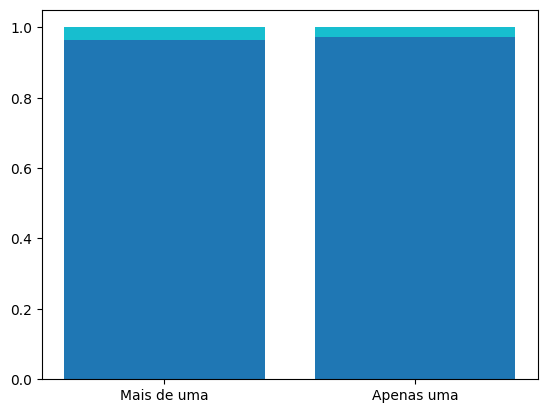

In [37]:
new_df = new_df.toPandas()

quant_pessoas_no_veiculo = new_df.quant_pessoas_no_veiculo
casos_positivos = new_df.taxa_casos_positivos
casos_negativos = new_df.taxa_casos_negativos

plt.bar(quant_pessoas_no_veiculo, casos_negativos, color="tab:blue")
plt.bar(quant_pessoas_no_veiculo, casos_positivos, bottom=casos_negativos, color="tab:cyan")
plt.show()

#### Hipótese 2 - Acidentes cuja causa se deve à ingestão de álcool ou outra substância, pelo pedestre ou pelo condutor, são mais comuns durante a noite

In [38]:
final_df = (
    df.select("id", "fase_dia", "causa_acidente")
    .distinct()
    .withColumn(
        "estado_mental_esta_alterado",
        when(col("causa_acidente").like("Ingest%"), 1).otherwise(0),
    )
    .groupBy("fase_dia")
    .agg(
        sum("estado_mental_esta_alterado").alias(
            "num_acidentes_c_estado_mental_alterado"
        ),
        count("id").alias("num_total_acidentes"),
    )
    .withColumn(
        "taxa_de_acidentes",
        col("num_acidentes_c_estado_mental_alterado")
        / col("num_total_acidentes")
        * 100,
    )
    .orderBy(col("taxa_de_acidentes").desc())
)

In [39]:
final_df.show()

+-----------+--------------------------------------+-------------------+------------------+
|   fase_dia|num_acidentes_c_estado_mental_alterado|num_total_acidentes| taxa_de_acidentes|
+-----------+--------------------------------------+-------------------+------------------+
|Plena Noite|                                 16094|             111167|14.477317909091727|
|  Amanhecer|                                  1500|              15588|  9.62278675904542|
|  Anoitecer|                                  1343|              17708| 7.584142760334313|
|  Pleno dia|                                  6965|             176266|3.9514143396911483|
+-----------+--------------------------------------+-------------------+------------------+



In [40]:
final_df.write.option("header", True).csv("./hipotese2")

#### Conclusão

A Hipótese 2, para a base de dados disponível, é verdadeira, pois os casos de acidentes cuja causa se deve a ingestão de álcool ou outra substância, pelo condutor ou pedestre, são mais comuns durante a noite.

#### Visualização

In [41]:
new_df = (
    final_df.withColumn(
        "taxa_casos_positivos",
        col("num_acidentes_c_estado_mental_alterado") / col("num_total_acidentes"),
    )
    .withColumn(
        "taxa_casos_negativos",
        (col("num_total_acidentes") - col("num_acidentes_c_estado_mental_alterado"))
        / col("num_total_acidentes"),
    )
    .select("fase_dia", "taxa_casos_positivos", "taxa_casos_negativos")
)

new_df.show()

+-----------+--------------------+--------------------+
|   fase_dia|taxa_casos_positivos|taxa_casos_negativos|
+-----------+--------------------+--------------------+
|Plena Noite| 0.14477317909091728|  0.8552268209090828|
|  Amanhecer|  0.0962278675904542|  0.9037721324095458|
|  Anoitecer| 0.07584142760334313|  0.9241585723966569|
|  Pleno dia|0.039514143396911484|  0.9604858566030885|
+-----------+--------------------+--------------------+



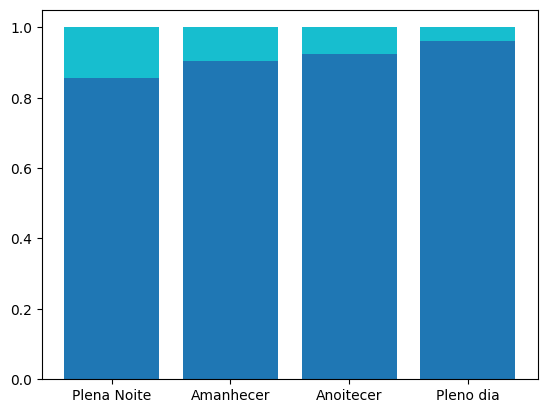

In [42]:
new_df = new_df.toPandas()

fase_dia = new_df.fase_dia
casos_positivos = new_df.taxa_casos_positivos
casos_negativos = new_df.taxa_casos_negativos

plt.bar(fase_dia, casos_negativos, color="tab:blue")
plt.bar(fase_dia, casos_positivos, bottom=casos_negativos, color="tab:cyan")
plt.show()